In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data

#  Determining Cryptos for Analysis

In [13]:
#getting TODAY's date
today = datetime.strftime(datetime.today(), "%m%d%y")

In [14]:
#defining function to read data from a given url
def getdata(url):
    r = requests.get(url,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    data = pd.read_html(r.text)
    return data

In [15]:
# defining function to get top 500 cryptos by marketcap off yahoo finance
def crypto_meta_marketcap(n_count=500):
    home = 'https://finance.yahoo.com/cryptocurrencies/'
    count = 100
    n_offset = n_count//count
    
    cryptos = None
    for o in range(n_offset):
        url = f'{home}?offset={o*100}&count={count}'
        df = getdata(url)[0]
        if cryptos is None:
            cryptos = pd.DataFrame(index=range(n_count), columns=df.columns)
        # print(cryptos, cryptos.loc[o*count:(o+1)*count], df, df.values)
        # print(len(cryptos), len(df.values))
        cryptos.iloc[o*count:(o+1)*count] = df
        
    return cryptos

In [16]:
#return a df of those top 500 cryptos
c = crypto_meta_marketcap()
c

,Select AllSymbol,Name,Price (Intraday),Change,% Change,Market Cap,Volume in Currency (Since 0:00 UTC),Volume in Currency (24Hr),Total Volume All Currencies (24Hr),Circulating Supply,52 Week Range,Day Chart
0,Select BTC-USDBTC-USD,Bitcoin USD,18795.56,-644.67,-3.32%,360.097B,37.846B,37.846B,37.846B,19.159M,NaN,NaN
1,Select ETH-USDETH-USD,Ethereum USD,1292.04,-38.05,-2.86%,158.268B,18.911B,18.911B,18.911B,122.495M,NaN,NaN
2,Select USDT-USDUSDT-USD,Tether USD,0.999994,-0.000056,-0.01%,67.954B,57.317B,57.317B,57.317B,67.955B,NaN,NaN
3,Select USDC-USDUSDC-USD,USD Coin USD,1.0001,-0.0001,-0.01%,49.837B,5.292B,5.292B,5.292B,49.834B,NaN,NaN
4,Select BNB-USDBNB-USD,BNB USD,271.4,-3.56,-1.29%,43.787B,867.73M,867.73M,867.73M,161.337M,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Select DG2-USDDG2-USD,Decentral Games USD,0.047893,-0.002864,-5.64%,27.336M,442789,442789,442789,570.78M,NaN,NaN
496,Select TKO-USDTKO-USD,Toko Token USD,0.251246,-0.001922,-0.76%,27.26M,1.613M,1.613M,1.613M,108.5M,NaN,NaN
497,Select SERO-USDSERO-USD,Super Zero Protocol USD,0.073722,-0.001283,-1.71%,27.2M,879436,879436,879436,368.951M,NaN,NaN
498,Select GMT1-USDGMT1-USD,GMT Token USD,0.102682,0.001373,+1.36%,27.065M,1.38M,1.38M,1.38M,263.581M,NaN,NaN


In [12]:
# get their date of inception by seeing when their first price entry was. Note that this is moreso the first time
# yahoo fin has data for them, but for the purposes of the analysis it doesn't matter
inception = [get_data(symbol, start_date='091714', end_date=today, index_as_date=True, interval='1wk').index[0] for symbol in c['Symbol']]
c['inception'] = inception
c[['Symbol', 'inception']]

KeyError: 'Symbol'

In [8]:
# seeing how old cryptos are in order to determine our analysis total times time (in years)
c['age'] = ((datetime.today() - c['inception']).dt.days)/365

(array([ 3.,  6.,  5., 12., 14., 19., 16., 16., 21., 25., 13., 33., 32.,
        22., 14., 10.,  7., 11.,  9., 16., 20., 11., 10.,  7., 11.,  7.,
        14.,  5., 16., 14., 78.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.02739726, 0.18734247, 0.34728767, 0.50723288, 0.66717808,
        0.82712329, 0.98706849, 1.1470137 , 1.3069589 , 1.46690411,
        1.62684932, 1.78679452, 1.94673973, 2.10668493, 2.26663014,
        2.42657534, 2.58652055, 2.74646575, 2.90641096, 3.06635616,
        3.22630137, 3.38624658, 3.54619178, 3.70613699, 3.86608219,
        4.0260274 , 4.1859726 , 4.34591781, 4.50586301, 4.66580822,
        4.82575342, 4.98569863, 5.14564384, 5.30558904, 5.46553425,
        5.62547945, 5.78542466, 5.94536986, 6.10531507, 6.26526027,
        6.42520548, 6.58515068, 6.74509589, 6.9050411 , 7.0649863 ,
        7.22493151, 7.38487671, 7.54482192, 7.70476712, 7.86471233,
        8.02465753]),
 <BarContainer

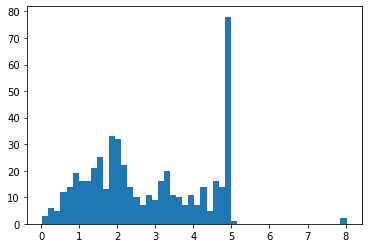

In [9]:
# plotting ages to determine decent value of total analysis time
plt.hist(c['age'].array, bins=50)

In [10]:
# From the graph we see that we can get a good amount of cryptos that are "older" than 4 years, take these
years = 4
crypstoclean = c[c['age'] > years]['Symbol'].reset_index(drop=True)

In [21]:
# make function to give you a dictionary with symbol and close prices for each crypto for the entire analysis time
# start and end date as string 'm/d/y'
# time interval as string ex: '1wk'
def analysisdata(symbols, startdate, enddate, tinterval):
    series = dict()
    for i in symbols:
        series[i] = get_data(i, start_date=startdate, end_date=enddate, index_as_date=True, interval=tinterval)['close']
    return series

In [12]:
# turn dictionary into a DataFrame
#use entire analysis time to determine which we symbols we will use
crypstocleandata = pd.DataFrame.from_dict(analysisdata(crypstoclean, '091718', today, '1wk'))

In [13]:
# array of which cryptos to drop from data (mean has to be greater than 1.01 or less than .98 over the entire time to not be considered stable coin)
drop = (crypstocleandata.mean()<.98).array + (crypstocleandata.mean()>1.01).array
crypstocleandata.head()

,BTC-USD,ETH-USD,USDT-USD,BNB-USD,XRP-USD,ADA-USD,DOGE-USD,TRX-USD,ETC-USD,LTC-USD,...,RFR-USD,UPP-USD,BCD-USD,PIVX-USD,ELA-USD,SBD-USD,PRE-USD,MONA-USD,BLZ-USD,GRS-USD
2018-09-17,6710.629883,244.330002,0.999512,10.28060,0.570689,0.089754,0.005901,0.023791,11.59860,61.366402,...,0.004136,0.027492,2.06767,0.977504,7.35875,1.025670,0.095707,1.37821,0.128594,0.578899
2018-09-24,6625.560059,232.848007,1.000360,10.01780,0.581572,0.085195,0.005906,0.022165,11.33200,61.141899,...,0.004403,0.026501,1.94940,1.111900,7.13009,1.011630,0.080757,1.33755,0.128123,0.559743
2018-10-01,6602.950195,226.119003,0.996617,10.51900,0.482039,0.084658,0.005562,0.026875,10.89810,58.160301,...,0.004507,0.026545,1.95133,1.073080,7.94287,0.983768,0.055097,1.15220,0.131439,0.550885
2018-10-08,6290.930176,195.714996,0.989570,9.49674,0.403286,0.071293,0.005158,0.023622,9.40812,52.187401,...,0.004916,0.028331,1.70589,1.111680,8.10389,1.015540,0.056346,1.15861,0.119386,0.540607
2018-10-15,6482.350098,205.141998,0.983548,9.74330,0.456694,0.075873,0.004517,0.024196,9.64013,52.915798,...,0.005640,0.027628,1.72449,1.305840,8.90458,1.001930,0.062904,1.15259,0.131991,0.544585


In [16]:
# final array with cryptos for analysis
cryptos = list(crypstocleandata.loc[:, drop ].columns)
cryptos

['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'BAT-USD',
 'DASH-USD',
 'WAVES-USD',
 'ZIL-USD',
 'RVN-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'DCR-USD',
 'HOT1-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'SC-USD',
 'POLY-USD',
 'VGX-USD',
 'ZEN-USD',
 'ERG-USD',
 'CHSB-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'LSK-USD',
 'EURS-USD',
 'CEEK-USD',
 'SYS-USD',
 'REN-USD',
 'SNT-USD',
 'MAID-USD',
 'ONG1-USD',
 'XNO-USD',
 'MVL-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'DENT-USD',
 'POWR-USD',
 'UQC-USD',
 'XYO-USD',
 'NMR-USD',
 '

In [18]:
cryptos = ['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'BAT-USD',
 'DASH-USD',
 'WAVES-USD',
 'ZIL-USD',
 'RVN-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'DCR-USD',
 'HOT1-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'SC-USD',
 'POLY-USD',
 'VGX-USD',
 'ZEN-USD',
 'ERG-USD',
 'CHSB-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'LSK-USD',
 'EURS-USD',
 'CEEK-USD',
 'SYS-USD',
 'REN-USD',
 'SNT-USD',
 'MAID-USD',
 'ONG1-USD',
 'XNO-USD',
 'MVL-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'DENT-USD',
 'POWR-USD',
 'UQC-USD',
 'XYO-USD',
 'NMR-USD',
 'BNT-USD',
 'STEEM-USD',
 'DAG-USD',
 'TEL-USD',
 'QKC-USD',
 'FUN-USD',
 'REP-USD',
 'STRAX-USD',
 'LOOM-USD',
 'MTL-USD',
 'XWC-USD',
 'STMX-USD',
 'REV1-USD',
 'ADS-USD',
 'ELF-USD',
 'VERI-USD',
 'VTHO-USD',
 'ANT-USD',
 'NKN-USD',
 'TRAC-USD',
 'AGIX-USD',
 'ETN-USD',
 'PRO-USD',
 'IQ-USD',
 'ARK-USD',
 'XVG-USD',
 'UTK-USD',
 'MFT-USD',
 'DERO-USD',
 'CXO-USD',
 'GXC-USD',
 'TIME-USD',
 'MLN-USD',
 'TOMO-USD',
 'AVA-USD',
 'CENNZ-USD',
 'WAN-USD',
 'KMD-USD',
 'BTS-USD',
 'FIRO-USD',
 'BMX-USD',
 'AOG-USD',
 'MOC-USD',
 'RFR-USD',
 'UPP-USD',
 'BCD-USD',
 'PIVX-USD',
 'ELA-USD',
 'SBD-USD',
 'PRE-USD',
 'MONA-USD',
 'BLZ-USD',
 'GRS-USD']

# Get all R matrices for Cryptos

In [19]:
# get n R matrices for our crypto symbols, input a start/end date as a string 'mdy', input epoch in integer days
# function calculates number n of matrices it will make (be careful must check it is an integer beforehand)
# initializes an empty array
# loops through starting at the original start date and gives a dictionary which we turn into a dataframe
# once a dataframe we perform some math operators and drop the first row (returns NaN values)
# then becomes R dataframe (matrix) and we append it to our array
# Does this for the entire data time and then returns the list of all the matrices
# note; here we make our R matrix have 1 day time intervals between data points 
# (not 1wk like we did above to determine symbols)
# note; yahoo fin requires at least a 1 month interval to pull data for some reason?
def rmatrices(startdate, enddate, epoch, cryptosymbols):
    n = int((datetime.strptime(enddate, '%m%d%y') - datetime.strptime(startdate, '%m%d%y')).days/epoch)
    matrices = list()
    print('expected number of matrices:', n)
    for i in range(n):
        tempdict = analysisdata(cryptosymbols, datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days=(i*epoch)), '%m%d%y'), datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days=((i+1)*epoch)), '%m%d%y'), tinterval= '1d')
        tempdf = pd.DataFrame.from_dict(tempdict)
        tempdftwo = np.log(tempdf).diff()
        r = tempdftwo.drop(index=tempdftwo.index[0])
        matrices.append(r)
    return matrices

In [22]:
# generate all R matrices in a list
rmatrix = rmatrices('100118','103118',10, cryptos)

expected number of matrices: 3


In [65]:
rmatrix

[             BTC-USD   ETH-USD   BNB-USD   XRP-USD   ADA-USD  DOGE-USD  \
 2018-10-02 -0.005100 -0.015666  0.040708 -0.101471 -0.023283 -0.020058   
 2018-10-03 -0.008195 -0.029899 -0.008299  0.013966 -0.021260 -0.020820   
 2018-10-04  0.011331  0.007811 -0.001520 -0.002950  0.006354 -0.010398   
 2018-10-05  0.006938  0.023935  0.036439 -0.014499  0.020537  0.004243   
 2018-10-06 -0.005173 -0.010961 -0.025144 -0.061471 -0.020549 -0.022116   
 2018-10-07  0.002220  0.004428  0.014064 -0.012458  0.040437  0.003061   
 2018-10-08  0.007436  0.013774 -0.001179  0.015872  0.022761  0.002873   
 2018-10-09 -0.001443 -0.005568 -0.011651 -0.020409 -0.002891  0.010167   
 2018-10-10 -0.008635 -0.009754 -0.005494 -0.037086 -0.019622 -0.014839   
 2018-10-11 -0.051295 -0.175129 -0.104702 -0.188028 -0.177047 -0.104720   
 
              TRX-USD   ETC-USD   LTC-USD  LINK-USD  ...   RFR-USD   UPP-USD  \
 2018-10-02  0.001858 -0.003744 -0.008384 -0.012771  ...  0.046963 -0.031984   
 2018-10-03 -

In [23]:
# get averages of each R matrix and put them in a list
raverages = list()
for i in range(len(rmatrix)):
    raverages.append(rmatrix[i].mean().mean())
    

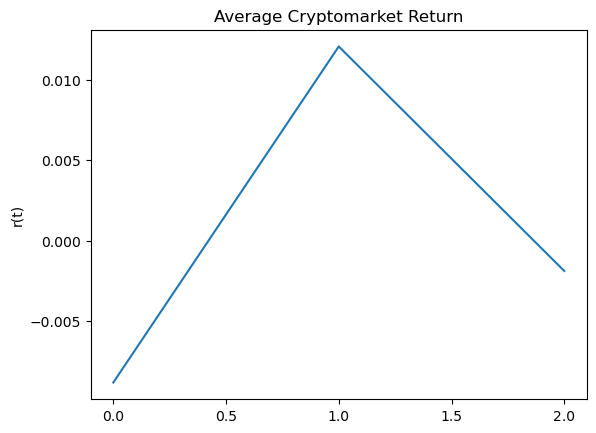

In [24]:
# going to plot r values. python will automatically plot in chronological order given how we constructed our data
labels = np.arange(2018,2022)
plt.style.use('default')
plt.plot(raverages)
plt.ylabel("r(t)")
plt.title('Average Cryptomarket Return')

plt.locator_params(axis='x', nbins=5)
plt.show()

# Getting all C matrices for Cryptos

In [25]:
# Get a Correlation Matrix for each R matrix
corrmatrix = [i.corr(method='pearson') for i in rmatrix]

In [26]:
# Get average correlation for each matrix [MIGHT NEED TO COME BACK AND DO NOISE SUPRESSION FIRST] 
# might need to subtract 1 for every mean since we have diagonals
corraverages = [i.mean().mean() for i in corrmatrix]

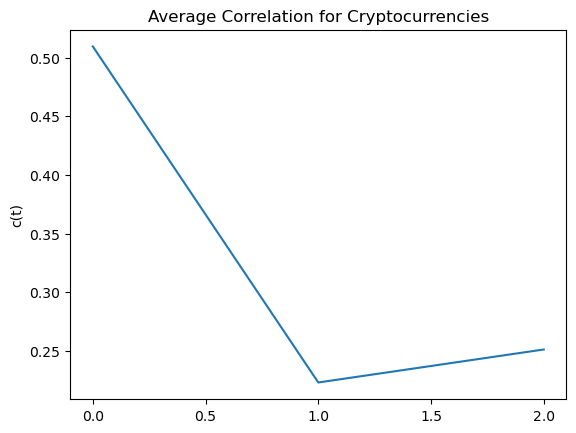

In [80]:
# Plot average correlation 
plt.style.use('default')
plt.plot(corraverages)
plt.ylabel("c(t)")
plt.title('Average Correlation for Cryptocurrencies')

plt.locator_params(axis='x', nbins=5)
plt.show()

# Noise Supression

In [75]:
# function which does power mapping for noise supresion, takes corr matrices and replaces each element by
# sign(C_ij)|C_ij|^(1+e)
def noisesupression(corrmatrices):
    for df in corrmatrices:
        for i,j in itertools.product(range(len(df.index)), range(len(df.columns))):
            df.iloc[i,j] = math.copysign(1,df.iloc[i,j])* abs((df.iloc[i,j]))**(1+e)
    return corrmatrices


In [76]:
# get supressed noise matrices
supcorrmatrix = noisesupression(corrmatrix)

In [78]:
supcorrmatrix[0]

,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD,DOGE-USD,TRX-USD,ETC-USD,LTC-USD,LINK-USD,...,RFR-USD,UPP-USD,BCD-USD,PIVX-USD,ELA-USD,SBD-USD,PRE-USD,MONA-USD,BLZ-USD,GRS-USD
BTC-USD,1.000000,0.966118,0.764789,0.797858,0.946873,0.911840,0.792602,0.901442,0.970748,0.764526,...,0.449920,0.506057,0.779233,0.104030,0.465825,-0.574623,0.049199,0.531510,0.818170,0.734363
ETH-USD,0.966118,1.000000,0.814400,0.773760,0.962223,0.950036,0.786597,0.957865,0.966763,0.782424,...,0.564807,0.623933,0.750296,0.065856,0.457485,-0.631169,0.031794,0.504767,0.886688,0.809353
BNB-USD,0.764789,0.814400,1.000000,0.483530,0.782316,0.755002,0.687007,0.820183,0.784631,0.745799,...,0.520329,0.635960,0.641527,0.030764,0.400324,-0.624843,-0.002952,0.398012,0.674948,0.545769
XRP-USD,0.797858,0.773760,0.483530,1.000000,0.820706,0.802910,0.583972,0.776841,0.718042,0.592961,...,0.348764,0.450473,0.625381,0.163138,0.456135,-0.516386,0.110314,0.567560,0.610150,0.656901
ADA-USD,0.946873,0.962223,0.782316,0.820706,1.000000,0.956272,0.864820,0.922443,0.942717,0.721633,...,0.463713,0.633370,0.719259,0.055157,0.476895,-0.521186,0.020467,0.526310,0.775053,0.779224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBD-USD,-0.574623,-0.631169,-0.624843,-0.516386,-0.521186,-0.502329,-0.401773,-0.756363,-0.523041,-0.416543,...,-0.504304,-0.325154,-0.773035,-0.004705,-0.323367,1.000000,-0.120270,-0.258446,-0.748231,-0.425816
PRE-USD,0.049199,0.031794,-0.002952,0.110314,0.020467,0.013664,-0.031834,0.079674,0.085052,-0.017472,...,0.234931,-0.226260,0.257625,0.341304,0.012491,-0.120270,1.000000,0.498011,0.155256,0.079403
MONA-USD,0.531510,0.504767,0.398012,0.567560,0.526310,0.566019,0.213179,0.528128,0.577516,0.369651,...,0.333772,0.134606,0.485376,0.245745,0.388752,-0.258446,0.498011,1.000000,0.471692,0.431519
BLZ-USD,0.818170,0.886688,0.674948,0.610150,0.775053,0.766545,0.583487,0.891665,0.852464,0.585989,...,0.617264,0.452666,0.783827,0.017969,0.318088,-0.748231,0.155256,0.471692,1.000000,0.702283
